In [1]:
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from transformers import PatchTSTConfig, PatchTSTForPrediction

torch.set_default_dtype(torch.double)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def create_dataset(dataset, block_length, device=None):
    X, Y = [], []
    for i in range(len(dataset)-block_length):
        x = dataset[i:i+block_length]
        y = dataset[i+1:i+block_length+1]
        X.append(x)
        Y.append(y)
    if device is not None:
        return torch.tensor(X, dtype=torch.double).to(device), torch.tensor(Y, dtype=torch.double).to(device)
    else:
        return np.array(X), np.array(Y)

In [3]:
# Compute self-influences

def calculate_self_tracin(
    model: torch.nn.Module,
    weights_paths: [str or Path],
    train_dataloader: torch.utils.data.DataLoader,
    work_dir: str or Path,
    nu_for_each_epoch: None
):

    LR = nu_for_each_epoch

    score_matrix = np.zeros((len(train_dataloader)))

    for train_id, (x_train, y_train) in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc='Train'):
        grad_sum = 0

        for w in weights_paths:
            model = PatchTSTForPrediction(config).to(device)
            model.load_state_dict(torch.load(w)) # checkpoint
            model.eval()
            inputs, targets = x_train.to(device), y_train.to(device)
            outputs = model(
                past_values=inputs,
                future_values=targets,
            )
            preds = outputs.prediction_outputs
            loss = nn.MSELoss()(targets, preds)
            loss.backward() # back
            train_grad = torch.cat([param.grad.reshape(-1) for param in model.parameters() if param.grad is not None])

            grad_sum += LR * np.dot(train_grad, train_grad) # scalar mult, TracIn formula

        score_matrix[train_id] = grad_sum

    return score_matrix

In [4]:
# Compute influences on test data

def calculate_tracin_score(
    model: torch.nn.Module,
    weights_paths: [str or Path],
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    work_dir: str or Path,
    nu_for_each_epoch: None
):

    LR = nu_for_each_epoch

    score_matrix = np.zeros((len(train_dataloader), len(test_dataloader)))

    for train_id, (x_train, y_train) in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc='Train'):

        for test_id, (x_test, y_test) in enumerate(test_dataloader):
            grad_sum = 0

            for w in weights_paths:
                model = PatchTSTForPrediction(config).to(device)
                model.load_state_dict(torch.load(w)) # checkpoint
                model.eval()
                inputs, targets = x_train.to(device), y_train.to(device)
                outputs = model(
                    past_values=inputs,
                    future_values=targets,
                )
                preds = outputs.prediction_outputs
                loss = nn.MSELoss()(targets, preds)
                loss.backward() # back
                train_grad = torch.cat([param.grad.reshape(-1) for param in model.parameters() if param.grad is not None])

                model = PatchTSTForPrediction(config).to(device)
                model.load_state_dict(torch.load(w)) # checkpoint
                model.eval()
                inputs, targets = x_train.to(device), y_train.to(device)
                outputs = model(
                    past_values=inputs,
                    future_values=targets,
                )
                preds = outputs.prediction_outputs
                loss = nn.MSELoss()(targets, preds)
                loss.backward() # back
                test_grad = torch.cat([param.grad.reshape(-1) for param in model.parameters() if param.grad is not None])

                grad_sum += LR * np.dot(train_grad, test_grad) # scalar mult, TracIn formula

            score_matrix[train_id][test_id] = grad_sum

    return score_matrix

In [5]:
# replace with the full dataset when running real experiments
block_length = 50
n_samples = 2000

bike_sharing = fetch_openml("Bike_Sharing_Demand", version=2, as_frame=True)
ts = bike_sharing['target'].to_numpy().reshape(-1,1)[:n_samples]
seq_len, n_dim = ts.shape

# standardize to prevent gradient explode
scaler = StandardScaler().fit(ts)
ts = scaler.transform(ts)
ts = ts.squeeze()

# i use this setup for univariate time series; can adjust the shape here to accommodate
# (n_samples, block_len, n_dim)
ts_train, ts_test = ts[:int(len(ts)*.8)], ts[int(len(ts)*.8):]
X_train, Y_train = create_dataset(ts_train, block_length=block_length, device=device)
X_train, Y_train = X_train[:,:,None], Y_train[:,-1,None,None]
X_test, Y_test = create_dataset(ts_test, block_length=block_length, device=device)
X_test, Y_test = X_test[:,:,None], Y_test[:,-1,None,None]
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

# still need to use match_train_time_block_index() to match time block to time point
# this is just for demo purpose

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


torch.Size([1550, 50, 1]) torch.Size([1550, 1, 1])
torch.Size([350, 50, 1]) torch.Size([350, 1, 1])


<ipython-input-2-33d38f65c627>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return torch.tensor(X, dtype=torch.double).to(device), torch.tensor(Y, dtype=torch.double).to(device)


In [6]:
# use a batch size of 1 bc otherwise TracIn will assign the same score
# for each time block in the batch
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train, Y_train), shuffle=True, batch_size=1
)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train, Y_train), shuffle=False, batch_size=1
)

In [7]:
# https://huggingface.co/docs/transformers/en/model_doc/patchtst#transformers.PatchTSTConfig


# use a very simple architecture
# can adjust according to the need
config = PatchTSTConfig(
    num_input_channels=n_dim,         # 1 for univariate ts
    context_length=block_length,      # context length of the input sequence
    patch_length=5,                   # each patch is a token
    prediction_length=1,              # prediction horizon (use 1 for our setting)
    num_hidden_layers=1,
    d_model=16,
    num_attention_heads=1,
    ffn_dim=32,
    attention_dropout=0.,
    dropout=0.,
    random_mask_ratio=0.1,
    num_targets=1,
)

In [12]:
learning_rate = 0.01 #0.001
model = PatchTSTForPrediction(config).to(device)
# TracIn only works with SGD so use SGD for now
# Adam and other optimizers need special treatment
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0)
# use this to collect checkpoints
weights = []

In [13]:
# for demo purpose; increase as needed
n_epochs = 50
for epoch in range(1, n_epochs):

    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # inputs: (bs, block_len, n_dim)
        # preds:  (bs, forecast_len, n_dim)

        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(
            past_values=inputs,
            future_values=targets,
        )
        preds = outputs.prediction_outputs
        loss = nn.MSELoss()(targets, preds)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
    print(f'epoch: {epoch} loss: {running_loss / len(train_loader):.5f}')
    running_loss = 0.0

    # IMPORTANT: need to cherry-pick where to save checkpoints
    # Can choose fewer checkpoints to speed up computation
    # Meanwhile, the author recommended to use checkpoints with larger reduction in loss
    # i.e., the earlier epochs when loss is still decreasing but not too early,
    # to ensure the TracIn scores are meaningful
    # see here: https://drive.google.com/file/d/1zL3hwW4wFru49_-zwpmliRDdCahjumXa/view
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f'model_v1_epoch_{epoch}')
        weights.append(f'model_v1_epoch_{epoch}')

print('Finished Training!')

epoch: 1 loss: 0.77294
epoch: 2 loss: 0.75948
epoch: 3 loss: 0.69326
epoch: 4 loss: 0.62070
epoch: 5 loss: 0.60793
epoch: 6 loss: 0.60929
epoch: 7 loss: 0.60406
epoch: 8 loss: 0.60123
epoch: 9 loss: 0.59991
epoch: 10 loss: 0.59918
epoch: 11 loss: 0.59891
epoch: 12 loss: 0.59794
epoch: 13 loss: 0.59538
epoch: 14 loss: 0.59213
epoch: 15 loss: 0.58932
epoch: 16 loss: 0.59567
epoch: 17 loss: 0.59374
epoch: 18 loss: 0.58701
epoch: 19 loss: 0.59820
epoch: 20 loss: 0.59217
epoch: 21 loss: 0.59126
epoch: 22 loss: 0.59586
epoch: 23 loss: 0.59142
epoch: 24 loss: 0.58887
epoch: 25 loss: 0.59301
epoch: 26 loss: 0.59016
epoch: 27 loss: 0.58781
epoch: 28 loss: 0.58802
epoch: 29 loss: 0.58899
epoch: 30 loss: 0.58962
epoch: 31 loss: 0.59072
epoch: 32 loss: 0.58484
epoch: 33 loss: 0.58785
epoch: 34 loss: 0.58220
epoch: 35 loss: 0.58782
epoch: 36 loss: 0.58729
epoch: 37 loss: 0.58320
epoch: 38 loss: 0.58421
epoch: 39 loss: 0.58160
epoch: 40 loss: 0.58332
epoch: 41 loss: 0.58297
epoch: 42 loss: 0.58297
e

In [14]:
# eval the trained patchTST
model.eval()
test_targets, test_preds = [], []
for i, data in enumerate(test_loader):
    inputs, targets = data
    inputs, targets = inputs.to(device), targets.to(device)

    outputs = model(
        past_values=inputs,
        future_values=targets,
    )
    preds = outputs.prediction_outputs
    test_targets.append(targets)
    test_preds.append(preds)
test_targets = torch.concat(test_targets).squeeze().detach().numpy()
test_preds = torch.concat(test_preds).squeeze().detach().numpy()

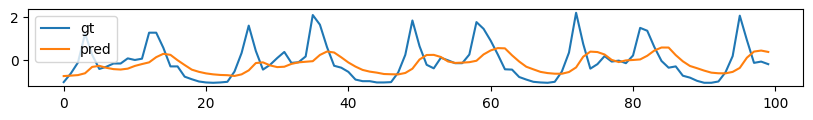

In [18]:
# the simple 1-layer patchTST generalizes to test data pretty well :)
plt.figure(figsize=(10,1))
plt.plot(test_targets[:100], label='gt')
plt.plot(test_preds[:100], label='pred')
plt.legend();

In [19]:
# IMPORTANT: For anomaly detection,
# I think the model training time should not be included in the computation time
# only the IF computation time will be included
# bc in reality we would take a pre-trained model with pre-saved checkpoints
# and then directly compute the TracIn

IF_block = calculate_self_tracin(
    model=PatchTSTForPrediction(config),
    weights_paths=weights,
    train_dataloader=train_loader,
    work_dir=None, nu_for_each_epoch=learning_rate
)
# nice - it only takes 1 min to compute IF for this simple patchTST :)

Train: 100%|██████████| 1550/1550 [01:31<00:00, 16.92it/s]


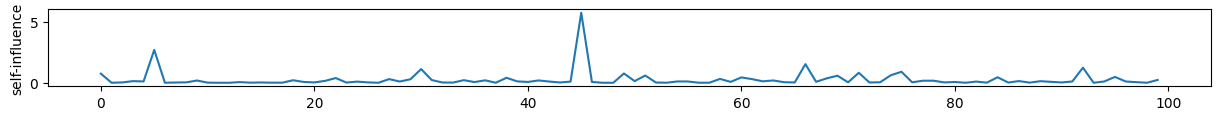

In [21]:
# computed self-influence for each time block
# still need to compute self-influence for each time point using the matched_index
# and then the usual stuffs with anomaly scores ...
plt.figure(figsize=(15,1))
plt.plot(IF_block[:100])
plt.ylabel('self-influence');